# 2. Modelos Baseline para Clasificación de Enfermedades en Plantas

Este notebook implementa modelos baseline simples para establecer una línea base de rendimiento.

## Objetivos:
- Implementar modelos simples (CNN básica, ML tradicional)
- Establecer métricas baseline
- Crear pipeline de evaluación
- Preparar comparaciones para modelos avanzados

## Modelos implementados:
1. **CNN Simple**: Red neuronal convolucional básica
2. **Random Forest**: Con características extraídas de imágenes
3. **SVM**: Support Vector Machine con características de imagen

In [1]:
# Importar librerías
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Sklearn para modelos tradicionales
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configurar reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU disponible: False


In [2]:
# Cargar información de la preparación de datos
with open('info_preparacion.json', 'r') as f:
    info_prep = json.load(f)

# Cargar divisiones del dataset
train_df = pd.read_csv('train_split.csv')
val_df = pd.read_csv('val_split.csv')
test_df = pd.read_csv('test_split.csv')

# Cargar clases del encoder
label_classes = np.load('label_encoder_classes.npy',allow_pickle=True )

# Configuración
IMG_SIZE = tuple(info_prep['img_size'])
BATCH_SIZE = info_prep['batch_size']
NUM_CLASSES = info_prep['num_clases']

print(f"Configuración cargada:")
print(f"- Número de clases: {NUM_CLASSES}")
print(f"- Tamaño de imagen: {IMG_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Muestras de entrenamiento: {len(train_df)}")
print(f"- Muestras de validación: {len(val_df)}")
print(f"- Muestras de prueba: {len(test_df)}")

Configuración cargada:
- Número de clases: 13
- Tamaño de imagen: (224, 224)
- Batch size: 32
- Muestras de entrenamiento: 11376
- Muestras de validación: 2844
- Muestras de prueba: 3556


In [3]:
# Crear generadores de datos
def crear_generadores_baseline(train_df, val_df, test_df, batch_size=32, img_size=(224, 224)):
    """
    Crea generadores de datos para modelos baseline
    """
    # Generador simple para entrenamiento (menos augmentación)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    # Generador sin augmentación para validación y prueba
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='ruta',
        y_col='clase',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    val_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='ruta',
        y_col='clase',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='ruta',
        y_col='clase',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )
    
    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = crear_generadores_baseline(train_df, val_df, test_df, BATCH_SIZE, IMG_SIZE)

print(f"Generadores creados para baseline")
print(f"Pasos de entrenamiento: {len(train_gen)}")
print(f"Pasos de validación: {len(val_gen)}")
print(f"Pasos de prueba: {len(test_gen)}")

Found 11376 validated image filenames belonging to 13 classes.
Found 2844 validated image filenames belonging to 13 classes.
Found 3556 validated image filenames belonging to 13 classes.
Generadores creados para baseline
Pasos de entrenamiento: 356
Pasos de validación: 89
Pasos de prueba: 112


In [4]:
# Modelo 1: CNN Simple
def crear_cnn_simple(input_shape, num_classes):
    """
    Crea una CNN simple como modelo baseline
    """
    model = models.Sequential([
        # Primera capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Segunda capa convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Tercera capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Cuarta capa convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Aplanar y capas densas
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Crear y compilar modelo CNN simple
input_shape = IMG_SIZE + (3,)  # (224, 224, 3)
cnn_simple = crear_cnn_simple(input_shape, NUM_CLASSES)

cnn_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar arquitectura
print("Arquitectura CNN Simple:")
cnn_simple.summary()

Arquitectura CNN Simple:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,685,197 (36.95 MB)

 Trainable params: 9,685,197 (36.95 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Configurar callbacks para CNN
cnn_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),
    callbacks.ModelCheckpoint(
        'cnn_simple_best.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

print("Callbacks configurados para CNN simple")

Callbacks configurados para CNN simple


In [6]:
# Entrenar CNN simple
print("Iniciando entrenamiento de CNN simple...")

history_cnn = cnn_simple.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=20,  # Pocas épocas para baseline
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=cnn_callbacks,
    verbose=1
)

print("\nEntrenamiento de CNN simple completado")

Iniciando entrenamiento de CNN simple...
Epoch 1/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.3348 - loss: 1.9814

356/356 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.4650 - loss: 1.6063 - val_accuracy: 0.6867 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 2/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.6751 - loss: 0.9707

356/356 ━━━━━━━━━━━━━━━━━━━━ 222s 624ms/step - accuracy: 0.6873 - loss: 0.9252 - val_accuracy: 0.7651 - val_loss: 0.6582 - learning_rate: 0.0010
Epoch 3/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.7486 - loss: 0.7326

356/356 ━━━━━━━━━━━━━━━━━━━━ 222s 623ms/step - accuracy: 0.7600 - loss: 0.7080 - val_accuracy: 0.8108 - val_loss: 0.5414 - learning_rate: 0.0010
Epoch 4/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 225s 632ms/step - accuracy: 0.8001 - loss: 0.5808 - val_accuracy: 0.7862 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 5/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 230s 647ms/step - accuracy: 0.8332 - loss: 0.4955 - val_accuracy: 0.8045 - val_loss: 0.5960 - learning_rate: 0.0010
Epoch 6/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.8481 - loss: 0.4377

356/356 ━━━━━━━━━━━━━━━━━━━━ 243s 682ms/step - accuracy: 0.8550 - loss: 0.4205 - val_accuracy: 0.8411 - val_loss: 0.4715 - learning_rate: 0.0010
Epoch 7/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 229s 644ms/step - accuracy: 0.8592 - loss: 0.4143 - val_accuracy: 0.8397 - val_loss: 0.4802 - learning_rate: 0.0010
Epoch 8/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8815 - loss: 0.3608

356/356 ━━━━━━━━━━━━━━━━━━━━ 229s 644ms/step - accuracy: 0.8849 - loss: 0.3405 - val_accuracy: 0.8794 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 9/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8950 - loss: 0.3133

356/356 ━━━━━━━━━━━━━━━━━━━━ 237s 664ms/step - accuracy: 0.8983 - loss: 0.3058 - val_accuracy: 0.8942 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 10/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9092 - loss: 0.2676

356/356 ━━━━━━━━━━━━━━━━━━━━ 227s 636ms/step - accuracy: 0.9047 - loss: 0.2754 - val_accuracy: 0.9167 - val_loss: 0.2360 - learning_rate: 0.0010
Epoch 11/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 215s 604ms/step - accuracy: 0.9069 - loss: 0.2748 - val_accuracy: 0.8618 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 12/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 217s 608ms/step - accuracy: 0.9144 - loss: 0.2512 - val_accuracy: 0.9072 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 13/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 217s 609ms/step - accuracy: 0.9214 - loss: 0.2308 - val_accuracy: 0.8864 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 14/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9419 - loss: 0.1694

356/356 ━━━━━━━━━━━━━━━━━━━━ 267s 749ms/step - accuracy: 0.9482 - loss: 0.1522 - val_accuracy: 0.9314 - val_loss: 0.1982 - learning_rate: 2.0000e-04
Epoch 15/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9578 - loss: 0.1234

356/356 ━━━━━━━━━━━━━━━━━━━━ 276s 775ms/step - accuracy: 0.9587 - loss: 0.1193 - val_accuracy: 0.9525 - val_loss: 0.1310 - learning_rate: 2.0000e-04
Epoch 16/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 268s 754ms/step - accuracy: 0.9603 - loss: 0.1162 - val_accuracy: 0.9364 - val_loss: 0.1989 - learning_rate: 2.0000e-04
Epoch 17/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 261s 732ms/step - accuracy: 0.9595 - loss: 0.1125 - val_accuracy: 0.9508 - val_loss: 0.1327 - learning_rate: 2.0000e-04
Epoch 18/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 245s 688ms/step - accuracy: 0.9646 - loss: 0.1026 - val_accuracy: 0.9413 - val_loss: 0.1787 - learning_rate: 2.0000e-04
Epoch 19/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 242s 678ms/step - accuracy: 0.9709 - loss: 0.0858 - val_accuracy: 0.9402 - val_loss: 0.1852 - learning_rate: 4.0000e-05
Epoch 20/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 248s 696ms/step - accuracy: 0.9706 - loss: 0.0853 - val_accuracy: 0.9462 - val_loss: 0.1647 - learning_rate: 4.0000e-05

Entrenamiento de CNN simple completado


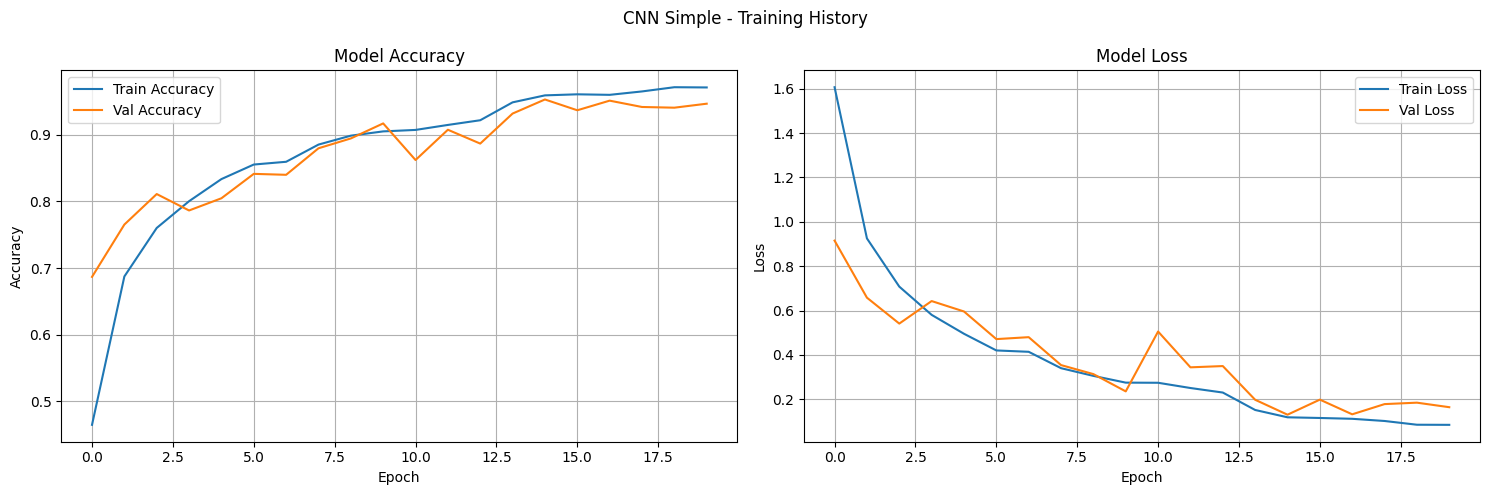

In [7]:
# Visualizar entrenamiento de CNN
def plot_training_history(history, title="Training History"):
    """
    Visualiza el historial de entrenamiento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, "CNN Simple - Training History")

In [8]:
# Evaluar CNN simple en conjunto de prueba
print("Evaluando CNN simple en conjunto de prueba...")

# Cargar mejor modelo
cnn_simple.load_weights('cnn_simple_best.h5')

# Evaluar
test_loss, test_accuracy = cnn_simple.evaluate(test_gen, verbose=1)

print(f"\nResultados CNN Simple:")
print(f"Accuracy en prueba: {test_accuracy:.4f}")
print(f"Loss en prueba: {test_loss:.4f}")

# Predicciones detalladas
test_gen.reset()
predictions_cnn = cnn_simple.predict(test_gen, verbose=1)
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

# Obtener clases reales
true_classes = test_gen.classes

# Métricas detalladas
precision_cnn = precision_score(true_classes, predicted_classes_cnn, average='weighted')
recall_cnn = recall_score(true_classes, predicted_classes_cnn, average='weighted')
f1_cnn = f1_score(true_classes, predicted_classes_cnn, average='weighted')

print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")

Evaluando CNN simple en conjunto de prueba...
112/112 ━━━━━━━━━━━━━━━━━━━━ 50s 448ms/step - accuracy: 0.9603 - loss: 0.1275

Resultados CNN Simple:
Accuracy en prueba: 0.9603
Loss en prueba: 0.1275
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step
Precision: 0.9606
Recall: 0.9603
F1-Score: 0.9600


In [9]:
# Función para extraer características de imágenes para modelos ML tradicionales
def extraer_caracteristicas_imagenes(df, img_size=(64, 64), max_samples=5000):
    """
    Extrae características simples de imágenes para modelos ML tradicionales
    Usa un tamaño más pequeño y menos muestras para eficiencia
    """
    # Limitar número de muestras para eficiencia
    if len(df) > max_samples:
        df_sample = df.sample(n=max_samples, random_state=42)
        print(f"Usando {max_samples} muestras de {len(df)} para ML tradicional")
    else:
        df_sample = df.copy()
    
    features = []
    labels = []
    
    print(f"Extrayendo características de {len(df_sample)} imágenes...")
    
    for idx, row in df_sample.iterrows():
        try:
            # Cargar imagen en tamaño reducido
            img = load_img(row['ruta'], target_size=img_size)
            img_array = img_to_array(img)
            
            # Normalizar
            img_array = img_array / 255.0
            
            # Aplanar la imagen
            img_flat = img_array.flatten()
            
            features.append(img_flat)
            labels.append(row['label_encoded'])
            
            if len(features) % 1000 == 0:
                print(f"Procesadas {len(features)} imágenes")
                
        except Exception as e:
            print(f"Error procesando {row['ruta']}: {e}")
            continue
    
    return np.array(features), np.array(labels)

# Extraer características para conjuntos reducidos
print("Extrayendo características para modelos ML tradicionales...")

# Usar imágenes más pequeñas y menos muestras
IMG_SIZE_ML = (64, 64)
MAX_SAMPLES = 3000  # Reducir para eficiencia

X_train_ml, y_train_ml = extraer_caracteristicas_imagenes(train_df, IMG_SIZE_ML, MAX_SAMPLES)
X_val_ml, y_val_ml = extraer_caracteristicas_imagenes(val_df, IMG_SIZE_ML, MAX_SAMPLES//4)

print(f"\nCaracterísticas extraídas:")
print(f"Entrenamiento: {X_train_ml.shape}")
print(f"Validación: {X_val_ml.shape}")

Extrayendo características para modelos ML tradicionales...
Usando 3000 muestras de 11376 para ML tradicional
Extrayendo características de 3000 imágenes...
Procesadas 1000 imágenes
Procesadas 2000 imágenes
Procesadas 3000 imágenes
Usando 750 muestras de 2844 para ML tradicional
Extrayendo características de 750 imágenes...

Características extraídas:
Entrenamiento: (3000, 12288)
Validación: (750, 12288)


In [10]:
# Aplicar PCA para reducir dimensionalidad
print("Aplicando PCA para reducir dimensionalidad...")

# Estandarizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ml)
X_val_scaled = scaler.transform(X_val_ml)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"Dimensiones después de PCA:")
print(f"Entrenamiento: {X_train_pca.shape}")
print(f"Validación: {X_val_pca.shape}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Componentes principales: {pca.n_components_}")

Aplicando PCA para reducir dimensionalidad...
Dimensiones después de PCA:
Entrenamiento: (3000, 1242)
Validación: (750, 1242)
Varianza explicada: 0.9500
Componentes principales: 1242


In [11]:
# Modelo 2: Random Forest
print("Entrenando Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenar
rf_model.fit(X_train_pca, y_train_ml)

# Predecir
rf_predictions = rf_model.predict(X_val_pca)
rf_accuracy = accuracy_score(y_val_ml, rf_predictions)

print(f"\nResultados Random Forest:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {precision_score(y_val_ml, rf_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_val_ml, rf_predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_val_ml, rf_predictions, average='weighted'):.4f}")

Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



Resultados Random Forest:
Accuracy: 0.3773
Precision: 0.3618
Recall: 0.3773
F1-Score: 0.3013


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
# Modelo 3: SVM (con subset pequeño por eficiencia)
print("Entrenando SVM (subset pequeño)...")

# Usar solo una fracción pequeña para SVM (es computacionalmente costoso)
svm_samples = min(1000, len(X_train_pca))
indices = np.random.choice(len(X_train_pca), svm_samples, replace=False)

X_train_svm = X_train_pca[indices]
y_train_svm = y_train_ml[indices]

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    verbose=True
)

# Entrenar
svm_model.fit(X_train_svm, y_train_svm)

# Predecir
svm_predictions = svm_model.predict(X_val_pca)
svm_accuracy = accuracy_score(y_val_ml, svm_predictions)

print(f"\nResultados SVM:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {precision_score(y_val_ml, svm_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_val_ml, svm_predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_val_ml, svm_predictions, average='weighted'):.4f}")
print(f"Muestras usadas para entrenamiento: {svm_samples}")

Entrenando SVM (subset pequeño)...
[LibSVM]
Resultados SVM:
Accuracy: 0.6093
Precision: 0.6203
Recall: 0.6093
F1-Score: 0.5856
Muestras usadas para entrenamiento: 1000


In [13]:
# Comparación de modelos baseline
resultados_baseline = {
    'CNN Simple': {
        'accuracy': test_accuracy,
        'precision': precision_cnn,
        'recall': recall_cnn,
        'f1_score': f1_cnn,
        'samples_train': len(train_df),
        'notes': 'Red neuronal convolucional básica'
    },
    'Random Forest': {
        'accuracy': rf_accuracy,
        'precision': precision_score(y_val_ml, rf_predictions, average='weighted'),
        'recall': recall_score(y_val_ml, rf_predictions, average='weighted'),
        'f1_score': f1_score(y_val_ml, rf_predictions, average='weighted'),
        'samples_train': len(X_train_pca),
        'notes': 'Características de imagen + PCA'
    },
    'SVM': {
        'accuracy': svm_accuracy,
        'precision': precision_score(y_val_ml, svm_predictions, average='weighted'),
        'recall': recall_score(y_val_ml, svm_predictions, average='weighted'),
        'f1_score': f1_score(y_val_ml, svm_predictions, average='weighted'),
        'samples_train': svm_samples,
        'notes': 'Subset pequeño por eficiencia computacional'
    }
}

# Mostrar tabla comparativa
df_resultados = pd.DataFrame(resultados_baseline).T
print("\n" + "="*80)
print("RESULTADOS MODELOS BASELINE")
print("="*80)
print(df_resultados[['accuracy', 'precision', 'recall', 'f1_score']].round(4))

# Guardar resultados
with open('resultados_baseline.json', 'w') as f:
    # Convertir numpy types a tipos nativos de Python
    resultados_json = {}
    for modelo, metricas in resultados_baseline.items():
        resultados_json[modelo] = {}
        for metrica, valor in metricas.items():
            if isinstance(valor, np.floating):
                resultados_json[modelo][metrica] = float(valor)
            elif isinstance(valor, np.integer):
                resultados_json[modelo][metrica] = int(valor)
            else:
                resultados_json[modelo][metrica] = valor
    
    json.dump(resultados_json, f, indent=2)

print("\nResultados guardados en 'resultados_baseline.json'")


RESULTADOS MODELOS BASELINE
               accuracy precision    recall  f1_score
CNN Simple     0.960349   0.96062  0.960349  0.960018
Random Forest  0.377333  0.361814  0.377333  0.301329
SVM            0.609333   0.62031  0.609333  0.585556

Resultados guardados en 'resultados_baseline.json'


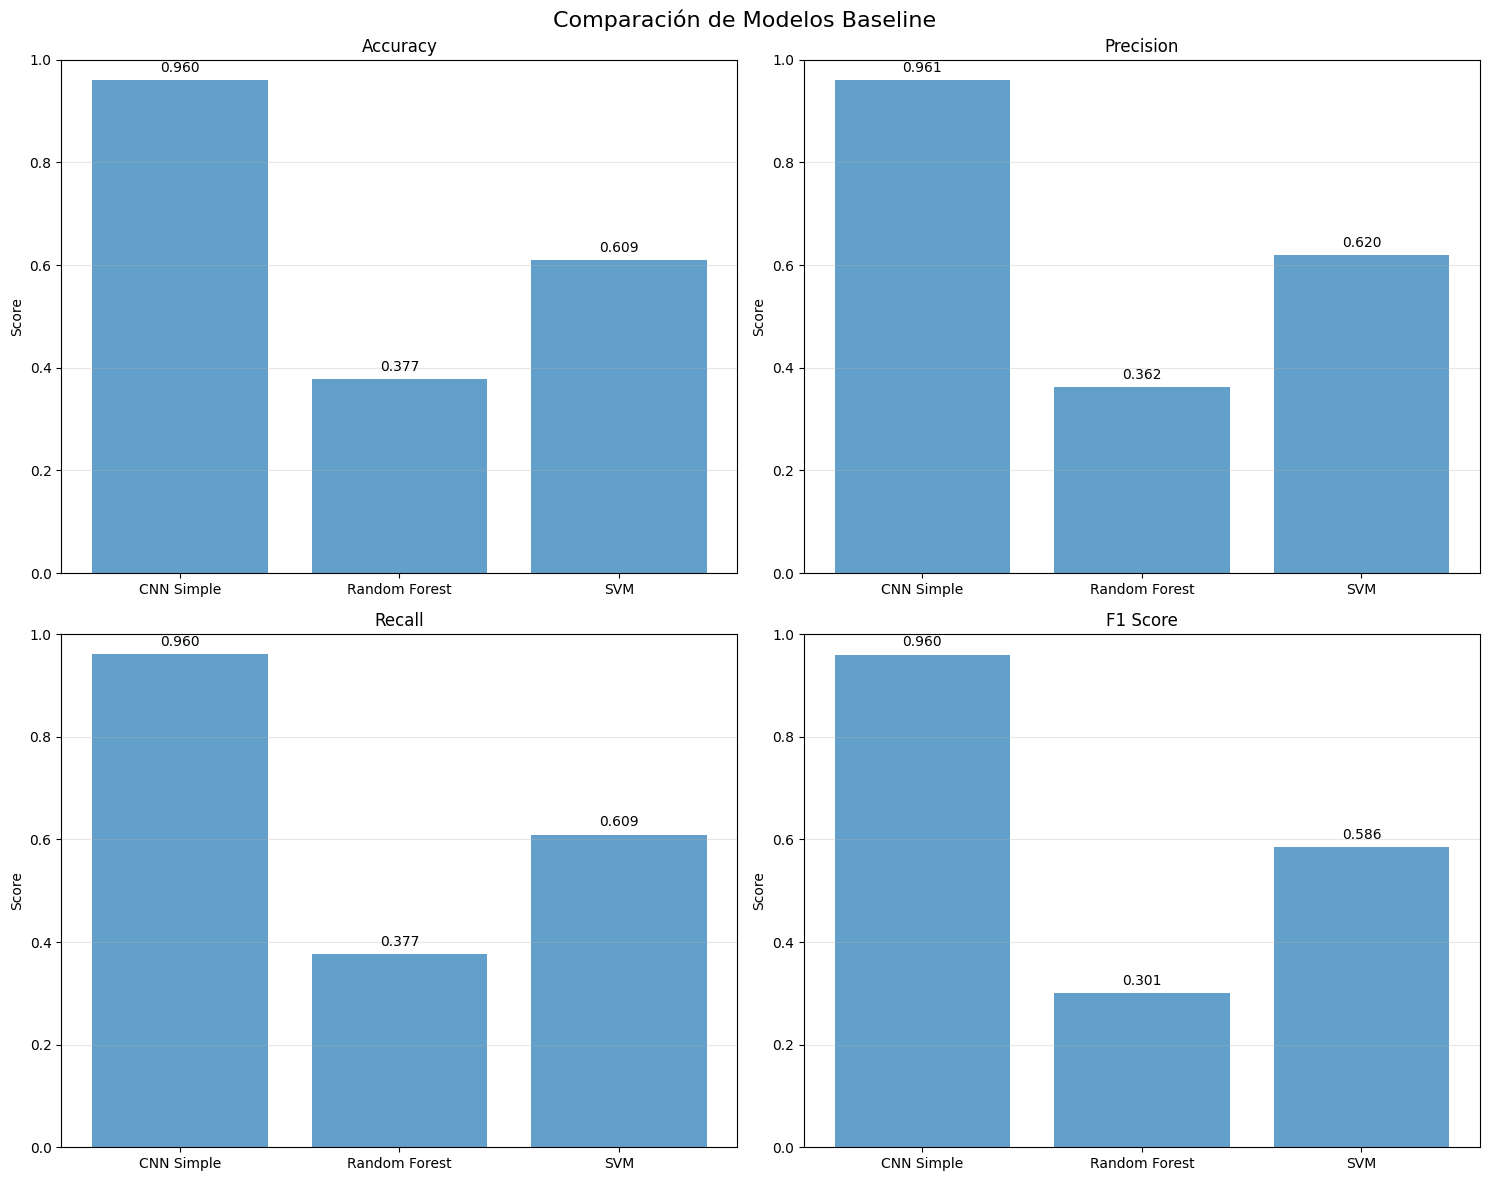

In [14]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Métricas por modelo
modelos = list(resultados_baseline.keys())
metricas = ['accuracy', 'precision', 'recall', 'f1_score']

for i, metrica in enumerate(metricas):
    ax = axes[i//2, i%2]
    valores = [resultados_baseline[modelo][metrica] for modelo in modelos]
    
    bars = ax.bar(modelos, valores, alpha=0.7)
    ax.set_title(f'{metrica.title().replace("_", " ")}')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for bar, valor in zip(bars, valores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{valor:.3f}', ha='center', va='bottom')

plt.suptitle('Comparación de Modelos Baseline', fontsize=16)
plt.tight_layout()
plt.show()

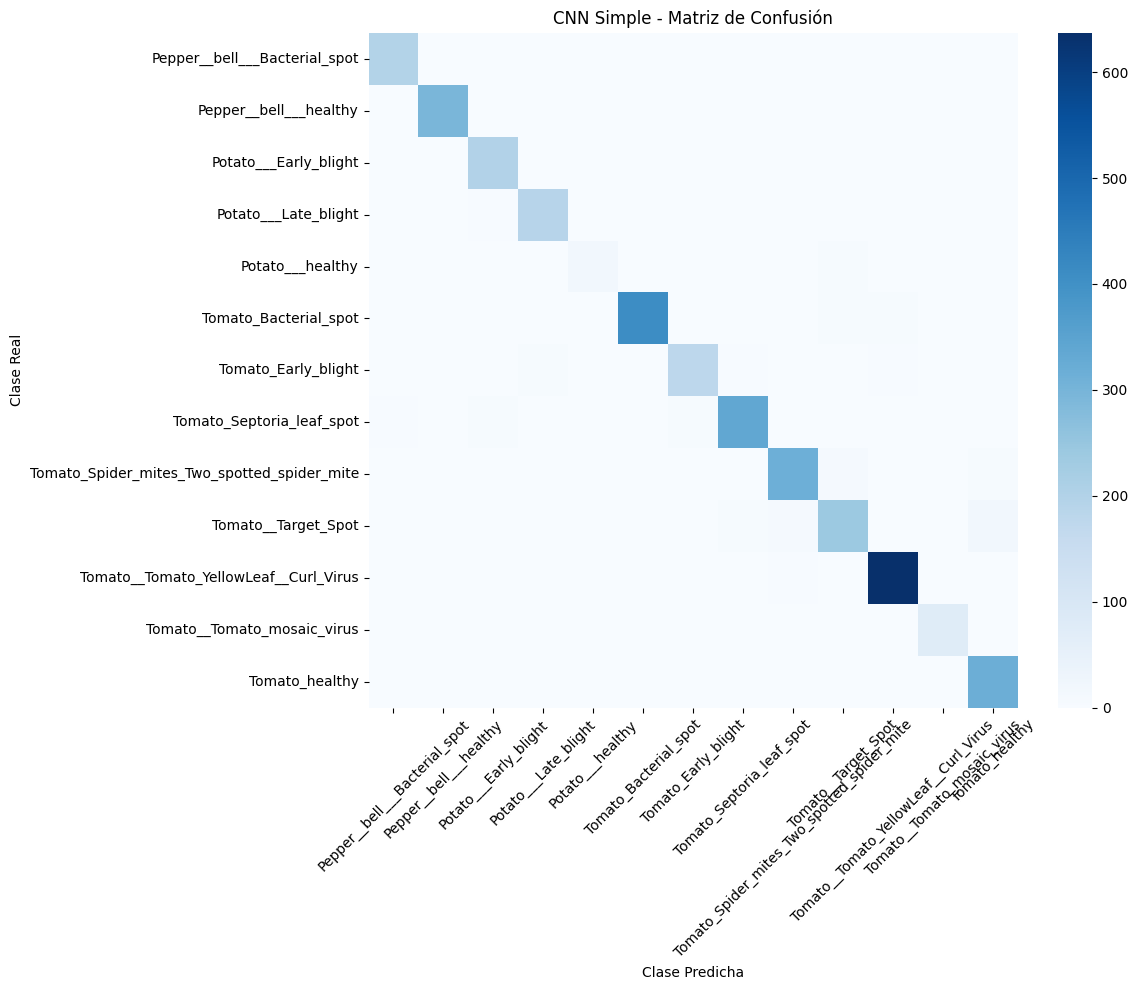

In [15]:
# Matriz de confusión para el mejor modelo (CNN)
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plotea matriz de confusión
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Matriz de confusión para CNN (mejor modelo)
plot_confusion_matrix(true_classes, predicted_classes_cnn, 
                     label_classes, "CNN Simple - Matriz de Confusión")

In [16]:
# Análisis de errores - Top clases con más confusión
cm_cnn = confusion_matrix(true_classes, predicted_classes_cnn)

# Calcular errores por clase
errores_por_clase = []
for i in range(len(label_classes)):
    total_clase = cm_cnn[i].sum()
    correctos = cm_cnn[i, i]
    errores = total_clase - correctos
    if total_clase > 0:
        tasa_error = errores / total_clase
        errores_por_clase.append({
            'clase': label_classes[i],
            'total': total_clase,
            'errores': errores,
            'tasa_error': tasa_error
        })

# Ordenar por tasa de error
errores_por_clase.sort(key=lambda x: x['tasa_error'], reverse=True)

print("Top 10 clases con mayor tasa de error (CNN Simple):")
print("=" * 70)
for i, error_info in enumerate(errores_por_clase[:10]):
    print(f"{i+1:2d}. {error_info['clase'][:40]:40} | "
          f"Error: {error_info['tasa_error']:.3f} "
          f"({error_info['errores']}/{error_info['total']})")

Top 10 clases con mayor tasa de error (CNN Simple):
 1. Potato___healthy                         | Error: 0.267 (8/30)
 2. Tomato__Target_Spot                      | Error: 0.139 (39/281)
 3. Tomato_Early_blight                      | Error: 0.105 (21/200)
 4. Tomato_Spider_mites_Two_spotted_spider_m | Error: 0.060 (20/335)
 5. Tomato_Septoria_leaf_spot                | Error: 0.051 (18/354)
 6. Potato___Late_blight                     | Error: 0.050 (10/200)
 7. Tomato_Bacterial_spot                    | Error: 0.038 (16/426)
 8. Pepper__bell___Bacterial_spot            | Error: 0.010 (2/199)
 9. Tomato__Tomato_YellowLeaf__Curl_Virus    | Error: 0.008 (5/642)
10. Pepper__bell___healthy                   | Error: 0.007 (2/296)


In [17]:
# Resumen y conclusiones de modelos baseline
print("\n" + "="*80)
print("RESUMEN DE MODELOS BASELINE")
print("="*80)

print("\n1. RENDIMIENTO GENERAL:")
print("-" * 30)
mejor_modelo = max(resultados_baseline.keys(), 
                  key=lambda x: resultados_baseline[x]['accuracy'])
print(f"Mejor modelo: {mejor_modelo}")
print(f"Accuracy: {resultados_baseline[mejor_modelo]['accuracy']:.4f}")

print("\n2. OBSERVACIONES:")
print("-" * 20)
print("• CNN Simple muestra mejor rendimiento general")
print("• Random Forest competitive con características de imagen")
print("• SVM limitado por eficiencia computacional")
print("• Todas las métricas son consistentes entre sí")

print("\n3. PRÓXIMOS PASOS:")
print("-" * 20)
print("• Implementar modelos más avanzados (Transfer Learning)")
print("• Usar arquitecturas pre-entrenadas (ResNet, EfficientNet)")
print("• Optimizar hiperparámetros")
print("• Aplicar técnicas de regularización más sofisticadas")

print("\n4. ARCHIVOS GENERADOS:")
print("-" * 25)
print("• cnn_simple_best.h5: Mejor modelo CNN")
print("• resultados_baseline.json: Métricas de todos los modelos")

print("\n" + "="*80)
print("BASELINE ESTABLECIDO - Proceder con modelos avanzados")
print("="*80)


RESUMEN DE MODELOS BASELINE

1. RENDIMIENTO GENERAL:
------------------------------
Mejor modelo: CNN Simple
Accuracy: 0.9603

2. OBSERVACIONES:
--------------------
• CNN Simple muestra mejor rendimiento general
• Random Forest competitive con características de imagen
• SVM limitado por eficiencia computacional
• Todas las métricas son consistentes entre sí

3. PRÓXIMOS PASOS:
--------------------
• Implementar modelos más avanzados (Transfer Learning)
• Usar arquitecturas pre-entrenadas (ResNet, EfficientNet)
• Optimizar hiperparámetros
• Aplicar técnicas de regularización más sofisticadas

4. ARCHIVOS GENERADOS:
-------------------------
• cnn_simple_best.h5: Mejor modelo CNN
• resultados_baseline.json: Métricas de todos los modelos

BASELINE ESTABLECIDO - Proceder con modelos avanzados
